# 1. Import Libraries

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#for topic modelling
from sklearn.decomposition import LatentDirichletAllocation

#for sentiment analysis - Transformers
import tensorflow as tf
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Import Data

In [2]:
from datasets import load_dataset

dataset = load_dataset("disaster_response_messages")

Generating train split:   0%|          | 0/21046 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2629 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2573 [00:00<?, ? examples/s]

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['split', 'message', 'original', 'genre', 'related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report'],
        num_rows: 21046
    })
    test: Dataset({
        features: ['split', 'message', 'original', 'genre', 'related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'e

In [43]:
import pandas as pd

# Convert each subset (train, test, validation) to a pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
validation_df = pd.DataFrame(dataset['validation'])

In [44]:
train_df

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21041,train,The training demonstrated how to enhance micro...,,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21042,train,A suitable candidate has been selected and OCH...,,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21043,train,"Proshika, operating in Cox's Bazar municipalit...",,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21044,train,"Some 2,000 women protesting against the conduc...",,news,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Combine the DataFrames
df = pd.concat([train_df, test_df, validation_df], ignore_index=True)

# 3. EDA

genre
news      13068
direct    10782
social     2398
Name: count, dtype: int64


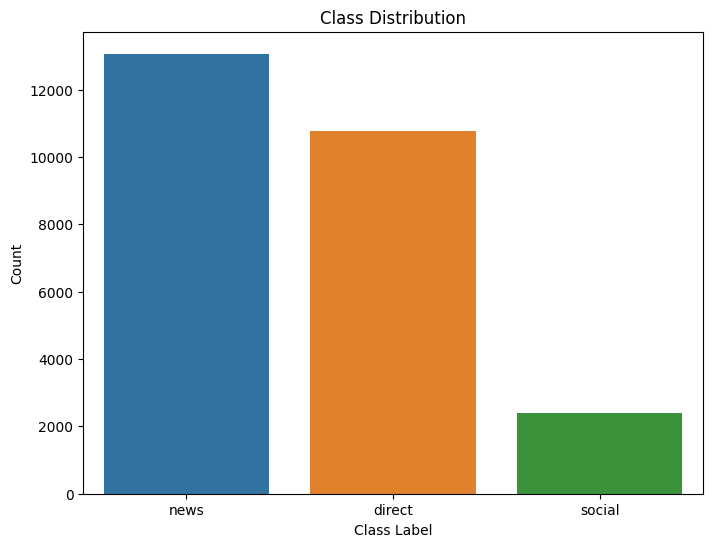

In [50]:
#1. Class Distribution
x=df['genre'].value_counts()
print(x)

# Check the class distribution
class_distribution = df['genre'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   split                   26248 non-null  object
 1   message                 26248 non-null  object
 2   original                26248 non-null  object
 3   genre                   26248 non-null  object
 4   related                 26248 non-null  int64 
 5   PII                     26248 non-null  int64 
 6   request                 26248 non-null  int64 
 7   offer                   26248 non-null  int64 
 8   aid_related             26248 non-null  int64 
 9   medical_help            26248 non-null  int64 
 10  medical_products        26248 non-null  int64 
 11  search_and_rescue       26248 non-null  int64 
 12  security                26248 non-null  int64 
 13  military                26248 non-null  int64 
 14  child_alone             26248 non-null  int64 
 15  wa

In [100]:
df['message'][199]

'Come help us because we do not have enough water and food. We are in delmas 16, 27'

In [55]:
#2. Missing Values
df.isna().sum()

split                     0
message                   0
original                  0
genre                     0
related                   0
PII                       0
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_related           0
floods                    0
storm               

In [63]:
#3. Word Count - Number of words in each message - 
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
print("News:", round(df[df['genre']=='news']['word_count'].mean(),2)) 
print("Direct: ", round(df[df['genre']=='direct']['word_count'].mean(),2)) 
print("Social: ", round(df[df['genre']=='social']['word_count'].mean(),2)) 

News: 30.09
Direct:  17.05
Social:  20.5


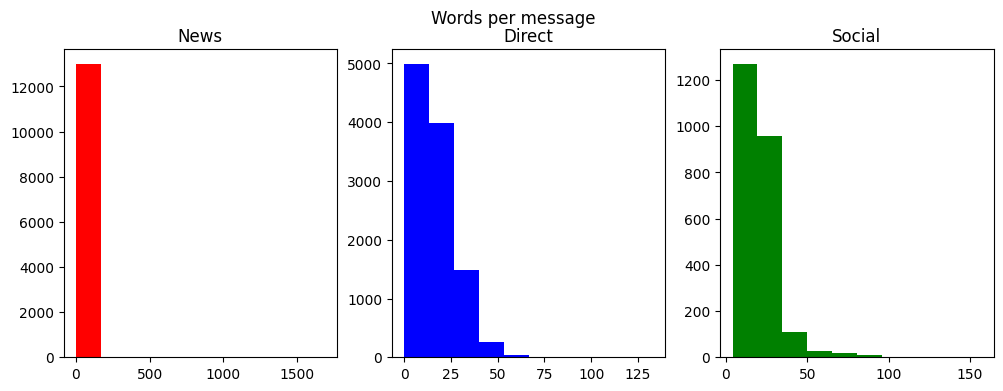

In [73]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

words=df[df['genre']=='news']['word_count']
ax1.hist(words,color='red')
ax1.set_title('News')

words=df[df['genre']=='direct']['word_count']
ax2.hist(words,color='blue')
ax2.set_title('Direct')

words=df[df['genre']=='social']['word_count']
ax3.hist(words,color='green')
ax3.set_title('Social')

fig.suptitle('Words per message')
plt.show()

In [75]:
#4. Character Count - Number of characters in a review
df['char_count'] = df['message'].apply(lambda x: len(str(x)))
print("News:", round(df[df['genre']=='news']['char_count'].mean(),2)) 
print("Direct: ", round(df[df['genre']=='direct']['char_count'].mean(),2)) 
print("Social: ", round(df[df['genre']=='social']['char_count'].mean(),2)) 

News: 193.17
Direct:  89.98
Social:  127.18


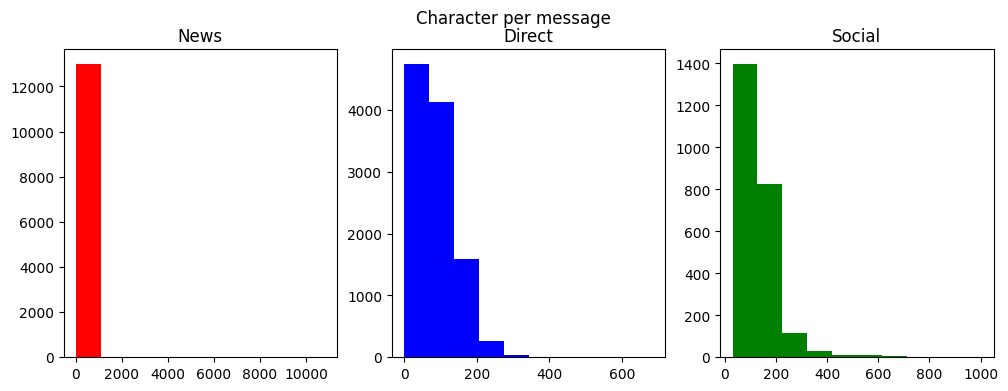

In [79]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

words=df[df['genre']=='news']['char_count']
ax1.hist(words,color='red')
ax1.set_title('News')

words=df[df['genre']=='direct']['char_count']
ax2.hist(words,color='blue')
ax2.set_title('Direct')

words=df[df['genre']=='social']['char_count']
ax3.hist(words,color='green')
ax3.set_title('Social')

fig.suptitle('Character per message')
plt.show()


# 4. Text Pre-Processing

In [80]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [82]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df['clean_message'] = df['message'].apply(lambda x: finalpreprocess(x))
df.head()

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,floods,storm,fire,earthquake,cold,other_weather,direct_report,word_count,char_count,clean_message
0,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,13,66,weather update cold front cuba could pass haiti
1,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,39,hurricane
2,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,12,63,say west side haiti rest country today tonight
3,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,38,information national palace
4,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,1,0,0,0,0,0,6,30,storm sacred heart jesus


# 5. Topic Modelling

In [93]:
#Document-Term Matrix
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(df['clean_message'])
dtm

<26248x13021 sparse matrix of type '<class 'numpy.int64'>'
	with 298362 stored elements in Compressed Sparse Row format>

In [94]:
#Latent Dirichlet Allocation
num_topics=3
lda = LatentDirichletAllocation(n_components=num_topics,random_state=42)

lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [95]:
# Print the top words for each topic
feature_names = cv.get_feature_names_out()
num_top_words = 10  # Adjust this based on how many top words you want to display for each topic

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-num_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: water, food, provide, government, health, include, supply, support, say, child
Topic #2: help, need, food, like, earthquake, people, http, know, haiti, information
Topic #3: people, flood, say, area, rain, million, province, year, damage, region


In [96]:
# Assign topics to documents in the DataFrame
df['Topic'] = lda.transform(dtm).argmax(axis=1) + 1
df

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,storm,fire,earthquake,cold,other_weather,direct_report,word_count,char_count,clean_message,Topic
0,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,13,66,weather update cold front cuba could pass haiti,3
1,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,...,1,0,0,0,0,0,9,39,hurricane,2
2,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,12,63,say west side haiti rest country today tonight,2
3,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,5,38,information national palace,2
4,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,1,0,0,0,0,0,6,30,storm sacred heart jesus,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,validation,"""With more than 7,500 people infected already ...",,news,1,0,1,0,1,1,...,0,0,0,0,0,0,30,209,people infect already virus spread rapidly vir...,1
26244,validation,About 70 percent of China's rivers and lakes a...,,news,1,0,0,0,0,0,...,0,0,0,0,0,0,20,121,percent china river lakes pollute due industri...,3
26245,validation,Senegal and Guinea-Bissau have agreed to condu...,,news,1,0,0,0,1,0,...,0,0,0,0,0,0,29,196,senegal guinea bissau agree conduct joint patr...,1
26246,validation,WHO is recruiting a sanitary engineer / consul...,,news,0,0,0,0,0,0,...,0,0,0,0,0,0,19,115,recruit sanitary engineer consultant february ...,1


# 6. Sentiment Analysis

In [98]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [106]:
def polarity_scores_roberta_tf(example, max_sequence_length=512):
    # Tokenize and run through the model
    encoded_text = tokenizer(example, return_tensors='tf', truncation=True, max_length=max_sequence_length)
    output = model(**encoded_text)

    # Convert TensorFlow tensor to NumPy array and apply softmax
    scores = tf.nn.softmax(output.logits[0]).numpy()

    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [113]:
polarity_scores_roberta_tf('Come help us because we do not have enough water and food. We are in delmas 16, 27')

{'roberta_neg': 0.62193006,
 'roberta_neu': 0.32704362,
 'roberta_pos': 0.05102639}

In [121]:
# Assuming df is your original DataFrame
df['Id'] = df.index
subset_df = df.sample(n=1000, random_state=42)

In [124]:
res = {}
for i, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    try:
        text = row['message']
        myid = row['Id']
        roberta_result = polarity_scores_roberta_tf(text)
        both = {**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [125]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,split,message,original,genre,related,PII,...,storm,fire,earthquake,cold,other_weather,direct_report,word_count,char_count,clean_message,Topic
0,11121,0.164934,0.705275,0.129791,train,China planned to parachute troops and supplies...,,news,1,0,...,1,0,0,0,0,0,65,465,china plan parachute troop supply wenchuan tue...,1
1,5215,0.819544,0.170395,0.010061,train,"I don't understand this message, can you pleas...",Mwen pa konprann mesaj la klarifyel voye pou m...,direct,0,0,...,0,0,0,0,0,0,12,66,understand message please clarify,2
2,11177,0.201299,0.727223,0.071478,train,"Contrary to the arrival of a warmer season, th...",,news,1,0,...,0,0,0,0,0,0,17,110,contrary arrival warmer season northeastern ja...,3
3,17684,0.215582,0.729115,0.055303,train,Following the nutrition assessment conducted i...,,news,1,0,...,0,0,1,0,0,0,64,443,follow nutrition assessment conduct tsunami af...,1
4,15832,0.213221,0.741909,0.044870,train,The hygiene and health situation in Yida remai...,,news,1,0,...,0,0,0,0,0,1,33,223,hygiene health situation yida remain serious c...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3396,0.209804,0.769921,0.020275,train,where can I get the card that PAM is given for...,KI B MAP JWEN KAT MANGE PAM AP BAY YO,direct,1,0,...,0,0,0,0,0,1,12,53,get card pam give food,2
996,22387,0.036728,0.938810,0.024463,test,Committee Chairman Aminu Masari had on Aug. 5 ...,,news,1,0,...,0,0,0,0,0,0,39,245,committee chairman aminu masari aug start exer...,3
997,9512,0.022589,0.406189,0.571222,train,"RT ikePortnoyDT: Well, the Santiago show is on...",,social,0,0,...,0,0,0,0,0,0,25,135,rt ikeportnoydt well santiago show however mov...,2
998,8518,0.082100,0.813308,0.104591,train,4 one gallon containers of water,,direct,0,0,...,0,0,0,0,0,0,6,32,one gallon container water,1


In [126]:
# Define a function to determine the sentiment based on the highest value
def determine_sentiment(row):
    if row['roberta_neg'] == max(row['roberta_neg'], row['roberta_neu'], row['roberta_pos']):
        return 'Desperation or Distress'
    elif row['roberta_pos'] == max(row['roberta_neg'], row['roberta_neu'], row['roberta_pos']):
        return 'Gratitude or Relief'
    else:
        return 'Neutral'

In [127]:
# Apply the function to create the 'Sentiment' column
results_df['Sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].apply(determine_sentiment, axis=1)

In [128]:
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,split,message,original,genre,related,PII,...,fire,earthquake,cold,other_weather,direct_report,word_count,char_count,clean_message,Topic,Sentiment
0,11121,0.164934,0.705275,0.129791,train,China planned to parachute troops and supplies...,,news,1,0,...,0,0,0,0,0,65,465,china plan parachute troop supply wenchuan tue...,1,Neutral
1,5215,0.819544,0.170395,0.010061,train,"I don't understand this message, can you pleas...",Mwen pa konprann mesaj la klarifyel voye pou m...,direct,0,0,...,0,0,0,0,0,12,66,understand message please clarify,2,Desperation or Distress
2,11177,0.201299,0.727223,0.071478,train,"Contrary to the arrival of a warmer season, th...",,news,1,0,...,0,0,0,0,0,17,110,contrary arrival warmer season northeastern ja...,3,Neutral
3,17684,0.215582,0.729115,0.055303,train,Following the nutrition assessment conducted i...,,news,1,0,...,0,1,0,0,0,64,443,follow nutrition assessment conduct tsunami af...,1,Neutral
4,15832,0.213221,0.741909,0.044870,train,The hygiene and health situation in Yida remai...,,news,1,0,...,0,0,0,0,1,33,223,hygiene health situation yida remain serious c...,1,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3396,0.209804,0.769921,0.020275,train,where can I get the card that PAM is given for...,KI B MAP JWEN KAT MANGE PAM AP BAY YO,direct,1,0,...,0,0,0,0,1,12,53,get card pam give food,2,Neutral
996,22387,0.036728,0.938810,0.024463,test,Committee Chairman Aminu Masari had on Aug. 5 ...,,news,1,0,...,0,0,0,0,0,39,245,committee chairman aminu masari aug start exer...,3,Neutral
997,9512,0.022589,0.406189,0.571222,train,"RT ikePortnoyDT: Well, the Santiago show is on...",,social,0,0,...,0,0,0,0,0,25,135,rt ikeportnoydt well santiago show however mov...,2,Gratitude or Relief
998,8518,0.082100,0.813308,0.104591,train,4 one gallon containers of water,,direct,0,0,...,0,0,0,0,0,6,32,one gallon container water,1,Neutral


Sentiment
Neutral                    557
Desperation or Distress    340
Gratitude or Relief        103
Name: count, dtype: int64


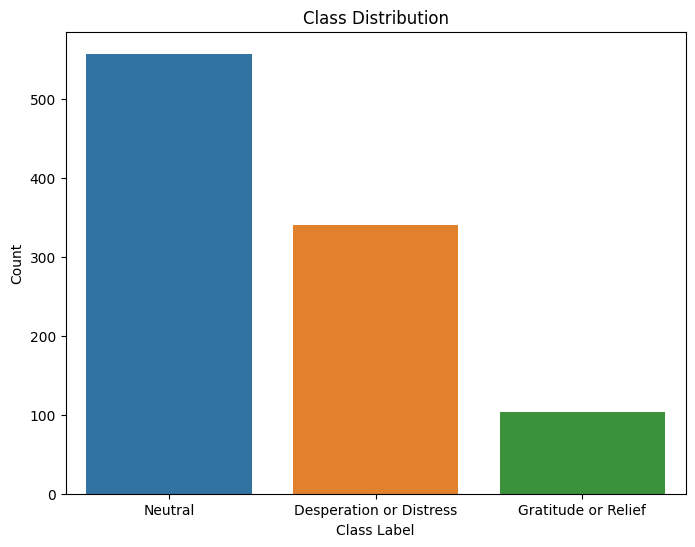

In [129]:
#1. Class Distribution
x=results_df['Sentiment'].value_counts()
print(x)

# Check the class distribution
class_distribution = results_df['Sentiment'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [130]:
# Create a new DataFrame with only rows where 'Sentiment' is either 'Desperation or Distress' or 'Gratitude or Relief'
filtered_df = results_df[results_df['Sentiment'].isin(['Desperation or Distress', 'Gratitude or Relief'])]

# Reset the index of the new DataFrame
filtered_df = filtered_df.reset_index(drop=True)

In [131]:
filtered_df

,Id,roberta_neg,roberta_neu,roberta_pos,split,message,original,genre,related,PII,...,fire,earthquake,cold,other_weather,direct_report,word_count,char_count,clean_message,Topic,Sentiment
0,5215,0.819544,0.170395,0.010061,train,"I don't understand this message, can you pleas...",Mwen pa konprann mesaj la klarifyel voye pou m...,direct,0,0,...,0,0,0,0,0,12,66,understand message please clarify,2,Desperation or Distress
1,18696,0.755931,0.236280,0.007789,train,The assembly recently ordered the destruction ...,,news,1,0,...,0,0,0,0,0,30,186,assembly recently order destruction mensah gui...,3,Desperation or Distress
2,24413,0.581543,0.395023,0.023434,validation,after each catastrophe which c' in this countr...,"Apre chak katastwof ki pase nan peyi a, nou to...",direct,1,0,...,0,0,0,0,0,32,186,catastrophe c country world master key always ...,1,Desperation or Distress
3,23307,0.018990,0.343140,0.637869,test,"Through these programmes, mothers learn how to...",,news,1,0,...,0,0,0,0,0,17,104,programme mother learn cook nutritious meal ev...,1,Gratitude or Relief
4,20446,0.748254,0.246810,0.004935,train,"Editor Mark Chavunduka and reporter Ray Choto,...",,news,1,0,...,0,0,0,0,0,36,232,editor mark chavunduka reporter ray choto arre...,1,Desperation or Distress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,6248,0.014837,0.177374,0.807788,train,"Thanks to God,i am not sick.Now,i would like t...",Gras a Dye m' pa malad. Kounyea se travay mwen...,direct,1,0,...,0,0,0,0,0,17,106,thanks god sick would like job like technician...,2,Gratitude or Relief
439,22803,0.747879,0.241191,0.010930,test,These people face a bleak winter either in win...,,news,1,0,...,0,0,1,0,0,26,166,people face bleak winter either winterized ten...,1,Desperation or Distress
440,6498,0.001784,0.012429,0.985788,train,"Good night darling i love you so much,may the ...","Bonne nuit cherie je t'aime beaucoup, que la p...",direct,0,0,...,0,0,0,0,0,26,137,good night darling love much may presence gog ...,2,Gratitude or Relief
441,14790,0.796660,0.197352,0.005987,train,"For over a month, as northeast Sri Lanka writh...",,news,1,0,...,0,0,0,0,0,37,217,month northeast sri lanka writhe grip clash re...,3,Desperation or Distress


d:\Softwares\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Softwares\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Softwares\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


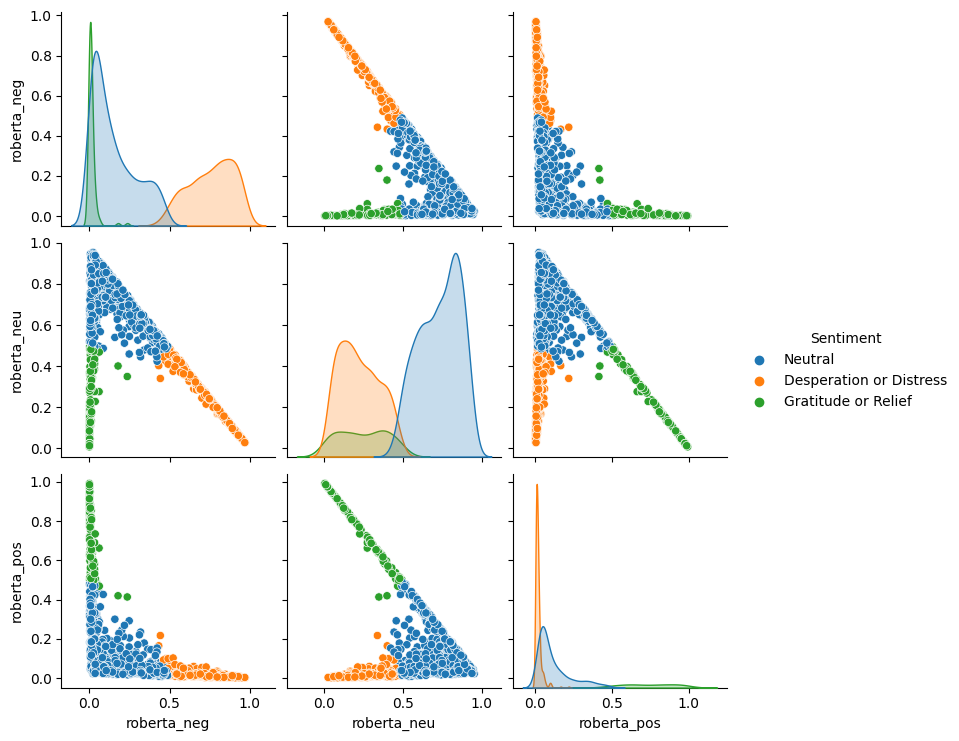

In [133]:
sns.pairplot(data=results_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Sentiment',
            palette='tab10')
plt.show()

In [ ]:
Desperation or Distress    340
Gratitude or Relief        103

In [135]:
# Negative - RoBERTa
results_df.query("Sentiment == 'Desperation or Distress'") \
    .sort_values('roberta_pos', ascending=False)['message'].values[3]

'People on top of Dekayete. Please help the babies, they are sick and need help please '

In [138]:
# Positive - RoBERTa
results_df.query("Sentiment == 'Gratitude or Relief'") \
    .sort_values('roberta_pos', ascending=False)['message'].values[3]

"God!bless Haiti for me! Thank's very much, GOD! "

# 7. Classification

In [140]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(filtered_df["clean_message"],filtered_df["Sentiment"],test_size=0.33,random_state=42)

print('Training Data Shape: ', X_train.shape)
print('Training Label Shape: ', y_train.shape)
print('Testing Data Shape: ', X_test.shape)
print('Testing Label Shape: ', y_test.shape)

Training Data Shape:  (296,)
Training Label Shape:  (296,)
Testing Data Shape:  (147,)
Testing Label Shape:  (147,)


In [141]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [164]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X_train_vectors_tfidf, X_test_vectors_tfidf, y_train, and y_test are already defined

# Convert the TF-IDF vectors to a dense matrix (required for XGBoost)
X_train_dense = X_train_vectors_tfidf.toarray()
X_test_dense = X_test_vectors_tfidf.toarray()

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Fit the XGBoost classifier to the training data
xgb_classifier.fit(X_train_dense, y_train_encoded)

# Predict y values for the test dataset
y_predict_xgb_encoded = xgb_classifier.predict(X_test_dense)

# Decode the predicted labels back to original labels
y_predict_xgb = label_encoder.inverse_transform(y_predict_xgb_encoded)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_predict_xgb))

# Print confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_predict_xgb)
print('Confusion Matrix:\n', conf_matrix_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       115
           1       0.68      0.53      0.60        32

    accuracy                           0.84       147
   macro avg       0.78      0.73      0.75       147
weighted avg       0.83      0.84      0.84       147

Confusion Matrix:
 [[107   8]
 [ 15  17]]


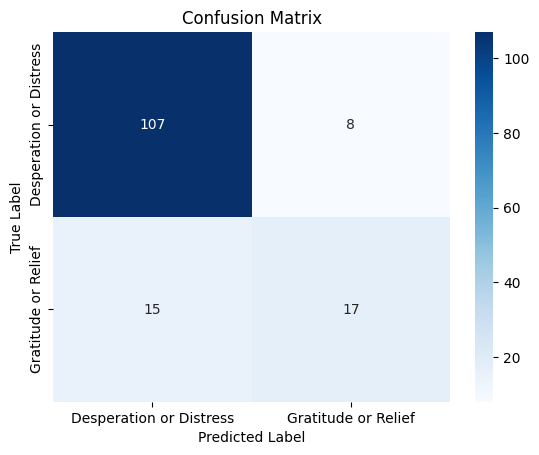

In [144]:
# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [146]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      443 non-null    int64  
 1   roberta_neg             443 non-null    float32
 2   roberta_neu             443 non-null    float32
 3   roberta_pos             443 non-null    float32
 4   split                   443 non-null    object 
 5   message                 443 non-null    object 
 6   original                443 non-null    object 
 7   genre                   443 non-null    object 
 8   related                 443 non-null    int64  
 9   PII                     443 non-null    int64  
 10  request                 443 non-null    int64  
 11  offer                   443 non-null    int64  
 12  aid_related             443 non-null    int64  
 13  medical_help            443 non-null    int64  
 14  medical_products        443 non-null    in

In [163]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Assuming df is your DataFrame with the provided features and 'Sentiment' column

# Define features and target
X = filtered_df.drop(['Sentiment','word_count','char_count','clean_message','Topic','Id',
                      'roberta_neg','roberta_neu','roberta_pos','split','message','original'], axis=1)  # Features
y = filtered_df['Sentiment']  # Target

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode categorical features
categorical_features = ['genre']  # Add other categorical features if needed
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.33, random_state=42)

# Initialize an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    max_depth=8,
    learning_rate=0.1,
    n_estimators=100,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27
)

# Fit the XGBoost classifier to the training data
xgb_classifier.fit(X_train, y_train)

# Predict y values for the test dataset
y_predict_xgb_encoded = xgb_classifier.predict(X_test)

# Convert numeric predictions back to original labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_predict_decoded = label_encoder.inverse_transform(y_predict_xgb_encoded)

# Print classification report
print("Classification Report:\n", classification_report(y_test_decoded, y_predict_decoded))

# Print confusion matrix
conf_matrix_xgb2 = confusion_matrix(y_test_decoded, y_predict_decoded)
print('Confusion Matrix:\n', conf_matrix_xgb)

Classification Report:
                          precision    recall  f1-score   support

Desperation or Distress       0.81      0.80      0.81       115
    Gratitude or Relief       0.32      0.34      0.33        32

               accuracy                           0.70       147
              macro avg       0.57      0.57      0.57       147
           weighted avg       0.71      0.70      0.70       147

Confusion Matrix:
 [[92 23]
 [21 11]]


In [157]:
filtered_df.shape

(443, 50)

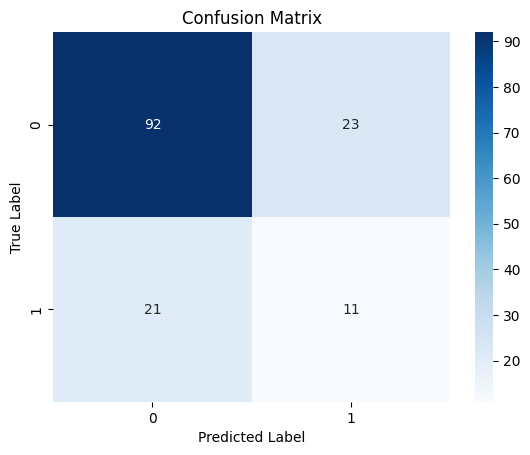

In [165]:
# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix_xgb2, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()